# Parameter Settings

In [45]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import torch.nn as nn
import torch.nn.functional as F
import sys
sys.path.append(os.path.abspath(os.path.join(os.path.dirname("./PROJECT"), '../..')))
import os
from PIL import Image
import torch
import torchvision.transforms as transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

latent_dims = 2
num_epochs = 100
batch_size = 32
image_size = 32
capacity = 64
learning_rate = 1e-3
variational_beta = 1
use_gpu = True
img_transform = transforms.Compose([
    transforms.ToTensor()
])


# Load Data

In [46]:
from Models.Util.loadData import create_hanzi_dataloaders
train_dataloader = create_hanzi_dataloaders(root_dir="../../Dataset/hanzi/processed", batch_size=batch_size,preprocess=img_transform)

VAE Definition
-----------------------
We use a convolutional encoder and decoder, which generally gives better performance than fully connected versions that have the same number of parameters.

In convolution layers, we increase the channels as we approach the bottleneck, but note that the total number of features still decreases, since the channels increase by a factor of 2 in each convolution, but the spatial size decreases by a factor of 4.

Kernel size 4 is used to avoid biasing problems described here: https://distill.pub/2016/deconv-checkerboard/

In [47]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        c = capacity
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=c, kernel_size=4, stride=2, padding=1) # out: c x 16 x 16
        self.conv2 = nn.Conv2d(in_channels=c, out_channels=c*2, kernel_size=4, stride=2, padding=1) # out: c x 8 x 8
        self.fc_mu = nn.Linear(in_features=c*2*8*8, out_features=latent_dims)
        self.fc_logvar = nn.Linear(in_features=c*2*8*8, out_features=latent_dims)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1) # flatten batch of multi-channel feature maps to a batch of feature vectors
        x_mu = self.fc_mu(x)
        x_logvar = self.fc_logvar(x)
        return x_mu, x_logvar

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        c = capacity
        self.fc = nn.Linear(in_features=latent_dims, out_features=c*2*8*8)
        self.conv2 = nn.ConvTranspose2d(in_channels=c*2, out_channels=c, kernel_size=4, stride=2, padding=1)
        self.conv1 = nn.ConvTranspose2d(in_channels=c, out_channels=1, kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), capacity*2, 8, 8) # unflatten batch of feature vectors to a batch of multi-channel feature maps
        x = F.relu(self.conv2(x))
        x = torch.sigmoid(self.conv1(x)) # last layer before output is sigmoid, since we are using BCE as reconstruction loss
        return x

class VariationalAutoencoder(nn.Module):
    def __init__(self):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        latent_mu, latent_logvar = self.encoder(x)
        latent = self.latent_sample(latent_mu, latent_logvar)
        x_recon = self.decoder(latent)
        return x_recon, latent_mu, latent_logvar

    def latent_sample(self, mu, logvar):
        if self.training:
            # the reparameterization trick
            std = logvar.mul(0.5).exp_()
            eps = torch.empty_like(std).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu

def vae_loss(recon_x, x, mu, logvar):
    # recon_x is the probability of a multivariate Bernoulli distribution p.
    # -log(p(x)) is then the pixel-wise binary cross-entropy.
    # Averaging or not averaging the binary cross-entropy over all pixels here
    # is a subtle detail with big effect on training, since it changes the weight
    # we need to pick for the other loss term by several orders of magnitude.
    # Not averaging is the direct implementation of the negative log likelihood,
    # but averaging makes the weight of the other loss term independent of the image resolution.
    recon_loss = F.binary_cross_entropy(recon_x.view(-1, 1024), x.view(-1, 1024), reduction='sum')

    # KL-divergence between the prior distribution over latent vectors
    # (the one we are going to sample from when generating new images)
    # and the distribution estimated by the generator for the given image.
    kldivergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return recon_loss + variational_beta * kldivergence


vae = VariationalAutoencoder()

device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
vae = vae.to(device)

num_params = sum(p.numel() for p in vae.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

Number of parameters: 321797


Train VAE
--------

In [48]:
optimizer = torch.optim.Adam(params=vae.parameters(), lr=learning_rate, weight_decay=1e-5)

# set to training mode
vae.train()

train_loss_avg = []

print('Training ...')

for epoch in tqdm(range(num_epochs), desc="Training Progress", unit="epoch"):
    train_loss_avg.append(0)
    num_batches = 0

    for image_batch, _ in train_dataloader:

        image_batch = image_batch.to(device)

        # vae reconstruction
        image_batch_recon, latent_mu, latent_logvar = vae(image_batch)

        # reconstruction error
        loss = vae_loss(image_batch_recon, image_batch, latent_mu, latent_logvar)

        # backpropagation
        optimizer.zero_grad()
        loss.backward()

        # one step of the optimizer (using the gradients from backpropagation)
        optimizer.step()

        train_loss_avg[-1] += loss.item()
        num_batches += 1


    train_loss_avg[-1] /= num_batches
    # print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))

Training ...


Training Progress: 100%|██████████| 100/100 [02:41<00:00,  1.62s/epoch]


Plot Training Curve
--------------------

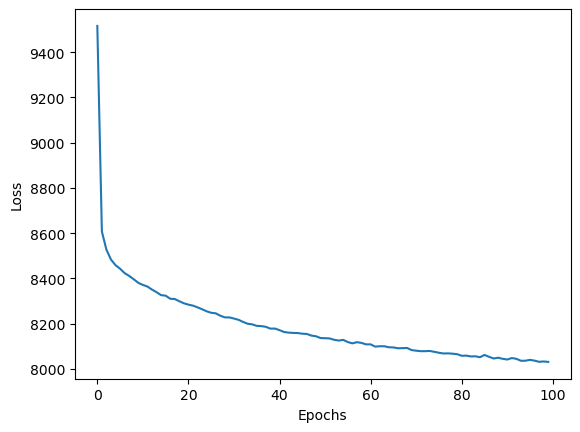

In [49]:
plt.ion()

fig = plt.figure()
plt.plot(train_loss_avg)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Save Model

In [60]:
torch.save(vae.state_dict(), './saves/my_vae.pth')

Visualize Reconstructions
--------------------------

Original images


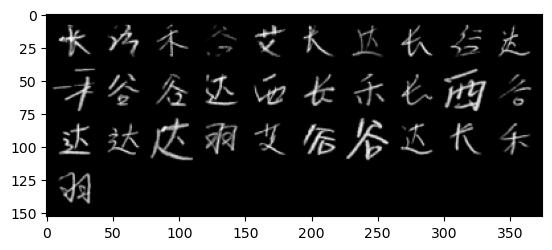

VAE reconstruction:


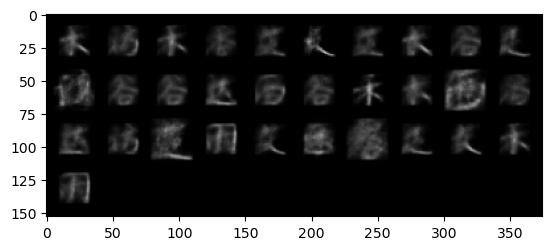

In [ ]:
plt.ion()

import torchvision.utils
vae.load_state_dict(torch.load('./saves/my_vae copy.pth'))
vae.eval()

# This function takes as an input the images to reconstruct
# and the name of the model with which the reconstructions
# are performed
def to_img(x):
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def visualise_output(images, model):

    with torch.no_grad():

        images = images.to(device)
        images, _, _ = model(images)
        images = images.cpu()
        images = to_img(images)
        np_imagegrid = torchvision.utils.make_grid(images[1:50], 10, 5).numpy()
        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
        plt.show()

images, labels = next(iter(train_dataloader))

# First visualise the original images
print('Original images')
show_image(torchvision.utils.make_grid(images[1:50],10,5))
plt.show()

# Reconstruct and visualise the images using the vae
print('VAE reconstruction:')
visualise_output(images, vae)

Interpolate in Latent Space
----------------------------

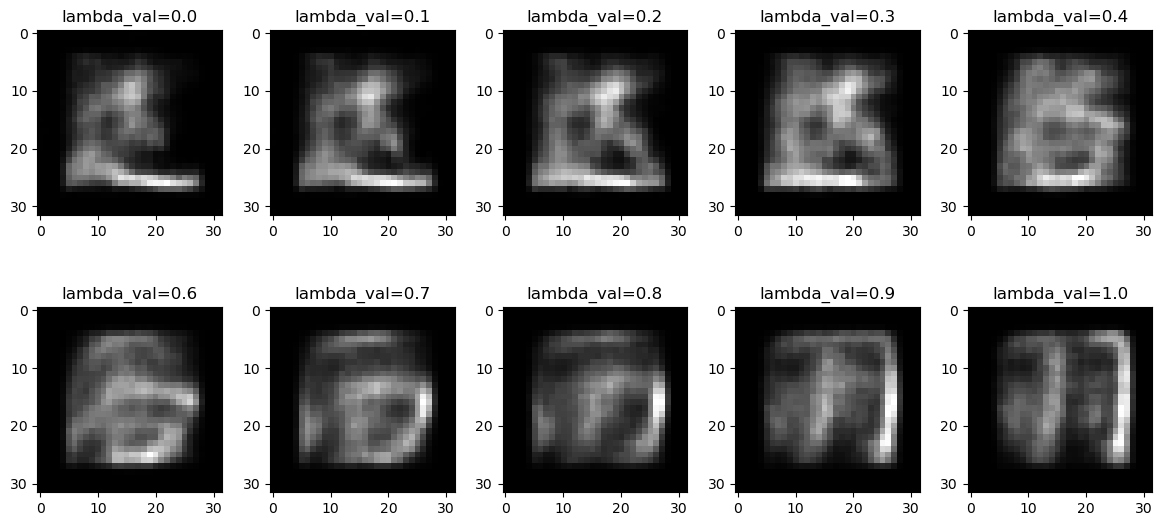

In [56]:
vae.eval()

def interpolation(lambda1, model, img1, img2):

    with torch.no_grad():

        # latent vector of first image
        img1 = img1.to(device)
        latent_1, _ = model.encoder(img1)

        # latent vector of second image
        img2 = img2.to(device)
        latent_2, _ = model.encoder(img2)

        # interpolation of the two latent vectors
        inter_latent = lambda1* latent_1 + (1- lambda1) * latent_2

        # reconstruct interpolated image
        inter_image = model.decoder(inter_latent)
        inter_image = inter_image.cpu()

        return inter_image

# sort part of test set by digit
digits = [[] for _ in range(10)]
for img_batch, label_batch in train_dataloader:
    for i in range(img_batch.size(0)):
        digits[label_batch[i]].append(img_batch[i:i+1])
    if sum(len(d) for d in digits) >= 1000:
        break;

# interpolation lambdas
lambda_range=np.linspace(0,1,10)

fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

for ind,l in enumerate(lambda_range):
    inter_image=interpolation(float(l), vae, digits[7][0], digits[1][0])

    inter_image = to_img(inter_image)

    image = inter_image.numpy()

    axs[ind].imshow(image[0,0,:,:], cmap='gray')
    axs[ind].set_title('lambda_val='+str(round(l,1)))
plt.show()

Sample Latent Vector from Prior (VAE as Generator)
-------------------------------------------------

A VAE can generate new digits by drawing latent vectors from the prior distribution. Although the generated digits are not perfect, they are usually better than for a non-variational Autoencoder (compare results for the 10d VAE to the results for the autoencoder).

Similar to autoencoders, the manifold of latent vectors that decode to valid digits is sparser in higher-dimensional latent spaces. Increasing the weight of the KL-divergence term in the loss (increasing `variational_beta`) makes the manifold less sparse at the cost of a lower-quality reconstruction. A pre-trained model with `variational_beta = 10` is available at `./pretrained/vae_10d_beta10.pth`.

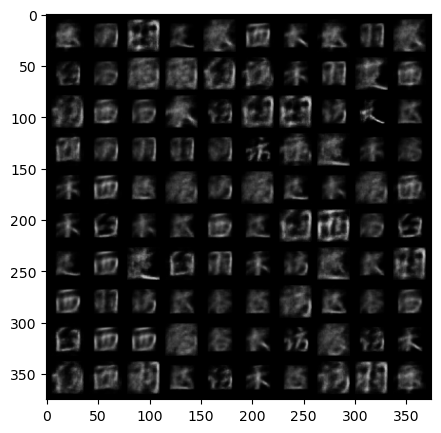

In [57]:
vae.eval()

with torch.no_grad():

    # sample latent vectors from the normal distribution
    latent = torch.randn(128, latent_dims, device=device)

    # reconstruct images from the latent vectors
    img_recon = vae.decoder(latent)
    img_recon = img_recon.cpu()

    fig, ax = plt.subplots(figsize=(5, 5))
    show_image(torchvision.utils.make_grid(img_recon.data[:100],10,5))
    plt.show()

Show 2D Latent Space
---------------------

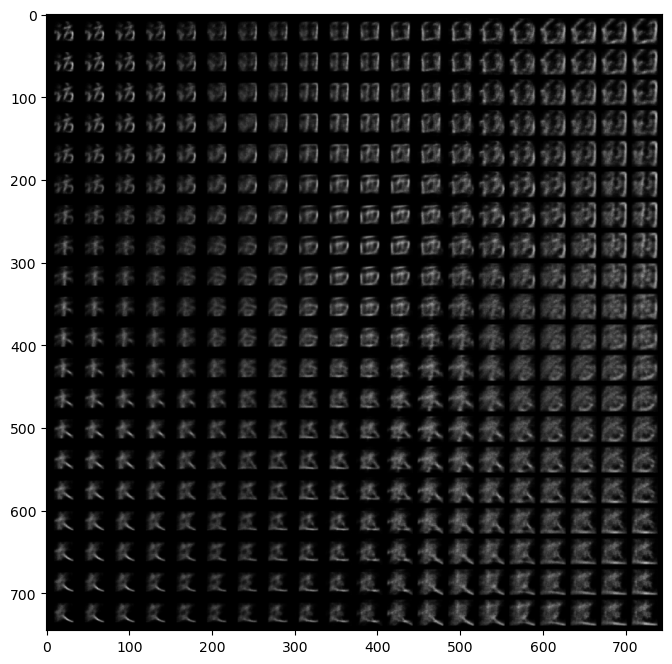

In [58]:
# load a network that was trained with a 2d latent space
if latent_dims != 2:
    print('Please change the parameters to two latent dimensions.')

with torch.no_grad():

    # create a sample grid in 2d latent space
    latent_x = np.linspace(-1.5,1.5,20)
    latent_y = np.linspace(-1.5,1.5,20)
    latents = torch.FloatTensor(len(latent_y), len(latent_x), 2)
    for i, lx in enumerate(latent_x):
        for j, ly in enumerate(latent_y):
            latents[j, i, 0] = lx
            latents[j, i, 1] = ly
    latents = latents.view(-1, 2) # flatten grid into a batch

    # reconstruct images from the latent vectors
    latents = latents.to(device)
    image_recon = vae.decoder(latents)
    image_recon = image_recon.cpu()

    fig, ax = plt.subplots(figsize=(8, 8))
    show_image(torchvision.utils.make_grid(image_recon.data[:400],20,5))
    plt.show()